# Implementing a Neural Network from Scratch in Python


### This notebook will implement a simple 3-layer neural network from scratch


Basic knowledge of Calculus, Machine Learning concepts and optimization techniques will be helpful to gain a full understanding of how neural networks work.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_style(style='white')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

## Generating a dataset

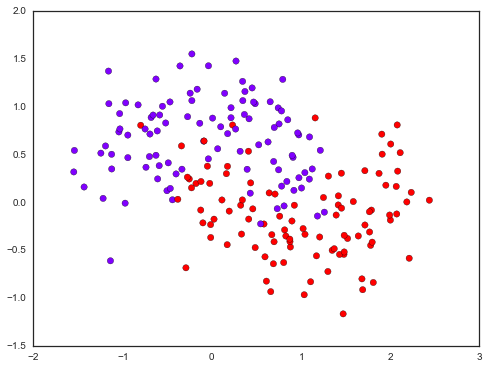

In [2]:
from sklearn import datasets
np.random.seed(0)
X, y = datasets.make_moons(n_samples=200, noise=0.3)
plt.scatter(X[:,0],X[:,1], s=40, c = y, cmap=plt.cm.rainbow);

The goal is to train a model using Machine Learning techniques that is able to separate accurately the two classes (purple and red).

## Logistic Regression

Let's see what a simple logictic regression can do for us.

In [3]:
from sklearn import linear_model
logit = linear_model.LogisticRegression()
logit.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [4]:
# Helper function to plot a decision boundary.

def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.rainbow)

(185628,) (372, 499)


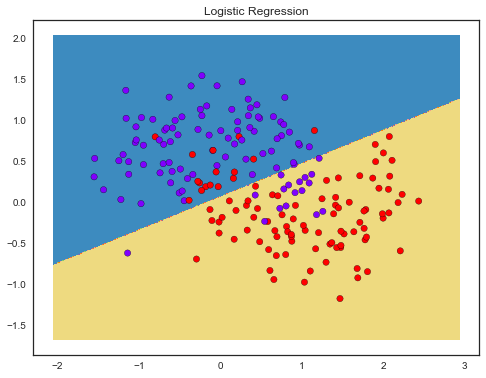

In [5]:
plot_decision_boundary(lambda x: logit.predict(x), X, y)
plt.title("Logistic Regression");

In [6]:
print "Accuracy: ",logit.score(X,y)

Accuracy:  0.835


With an accuracy of 83.5%, the logistic regression model was able to some extent differentiate the classes. However, from the plot we can observe that it was not able to capture the true wavy pattern in the data. In fact, unless we engineer specific non-linear features, a logistic regression model can only produce a linear decision boundary. 

What we need is a model that is able to engineer its own non-linear features.

## Training a Neural Network

** Model Architecture**

Let’s now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data. Similarly, the number of nodes in the output layer is determined by the number of classes we have.

![](image/neural_net.jpeg)

### Hidden Layer

What we can choose is the number  of nodes we want to have in the hidden layer. The higher the size of this layer, the more complex functions the model will be able to aproximate. This is exactly what we will need to obtain the non-linear decicsion boundary for the data.

However higher dimensionality also has its drawbacks:
* higher computation for training
* risk of overfitting data

Because of this tradeoff it is not always obvious what the size of the hidden layer should be. In this notebook we will expermiment with different number of nodes in the hidden layer and see how it affects our decicsion boundary.

### Activation Function

The hidden nodes use an activation function to apply a transformation to the data. These functions are non-linear and make it possible to represent the data in terms of non-linear  features. In this notebook, we will use the tanh function as the activation function. However, other popular functions include the sigmoid function or rectified linear function. 

![](image/Activation_functions.png)

The activation function of the output layer is the softmax function. This function takes a score and transforms it into a probability. It is a generalization of the logistic regression for multiple classes

$$P(y^{(i)} = k | x^{(i)} ; \theta) = \frac{\exp(\theta^{(k)\top} x^{(i)})}{\sum_{j=1}^K \exp(\theta^{(j)\top} x^{(i)}) }$$

### Forward Propagation

 Forward propagation is what allows the neural net to make its prediction. It is basically a series of matrix multiplications with the application of the activation function at every layer. This process transforms the data into a new distorted input vector space that allows easily separation of the classes.
 
In the image below we can observe that the nonlinear decision boundary becomes linear in the new representation constructed by the neural network. 

![](image/Forward_prop.png)

For this 3-layer neural network, the forward propagation is represented mathematically as follows:

$$ z_{1} = W_{1} x + b_{1} $$
$$ a_{1} = tanh(z_{1}) $$
$$ z_{2} = W_{2} a_{1} + b_{2} $$
$$ h_{W,b}(x) = a_{2} = softmax(z_{2}) $$


### Loss Function

For the forward propagation to make good predictions, the neural network needs to learning the weight and bias parameters ($W_1$, $b_1$, $W_2$, $b_2$). To do so we need to minimize the loss function, which gives a measure of the total error in the model. Given the softmax output, the categorical cross-entropy loss will be such function. It is also known as the negative log likelihood. In other words, the parameters need to be tuned such that they maximize the likelihood of our training data.

$$L(W,b) = -\frac{1}{N} \sum_{n=1}^{N} y_n log h_{W,b}(x) + (1-y_n)log(1-h_{W,b}(x)) $$

### Backpropagation

For this first implementation a simple batch gradient descent with a fixed learning rate will be used. Backpropagation is an efficient process that calculates the gradient at every nodes starting from the output. This allows the errors to be propagated across all layers and the weights to be updated appropriately.

$$
\delta_3 = y - h_{W,b}(x) \\
\delta_2 = (1-tanh^2z_1)\delta_3 W_2^T $$

$$
\frac{\partial L} {\partial W_2} = a_2^T \delta_3 \\
\frac{\partial L} {\partial b_2} = \delta_3 $$

$$
\frac{\partial L} {\partial W_1} = x^T \delta_2 \\
\frac{\partial L} {\partial b_1} = \delta_2 $$

One iteration of gradient descent updates the parameters $W$, $b$ as follows:

\begin{align}
W_i &= W_i - \alpha \frac{\partial L} {\partial W_i} \\
b_i &= b_i - \alpha \frac{\partial L} {\partial W_i}
\end{align}

## Neural Network Implementation

The Neural Net class below instantiate a 3 layer neural net with the given input and output dimensions. It defines three main functions. One that builds the model with the specified hyperparameters. Another, takes the trained model and predicts the class with a given input. The last one claculates the loss function for progress tracking while training.

In [7]:
from collections import defaultdict

class NeuralNet(object):
    def __init__(self, input_dim, output_dim):
        self.nn_input_dim = input_dim # input layer dimensionality
        self.nn_output_dim = output_dim # output layer dimensionality
    
    def forward_prop(self, X):
        """
        Forward propagation to calculate output probabilities
        """
        W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']

        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return probs, a1
        
    
    def calculate_loss(self, X):
        """
        function to evaluate the total loss on the dataset
        """
        probs, _ = self.forward_prop(X)
    
        # Calculating the loss
        corect_logprobs = -np.log(probs[range(self.num_examples), y])
        data_loss = np.sum(corect_logprobs)
        
        W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']
        
        # Add regulatization term to loss
        data_loss += self.reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
        return 1./self.num_examples * data_loss
    
    def predict(self, X):
        """
        Function predicts class label based on output probabilities
        """
        probs, _ = self.forward_prop(X)
        return np.argmax(probs, axis=1)
    
    def build_model(self, X, nn_hdim, epsilon = 0.01, reg_lambda = 0.01, num_passes = 10000, print_loss = False):
        """
        function initializes parameters and performs backpropagation and batch gradient descent
        """
        self.num_examples = len(X)
        self.reg_lambda = reg_lambda
        
        # Initialize the parameters to random values
        np.random.seed(0)
        W1 = np.random.randn(self.nn_input_dim, nn_hdim) / np.sqrt(self.nn_input_dim)
        b1 = np.zeros((1, nn_hdim))
        W2 = np.random.randn(nn_hdim, self.nn_output_dim) / np.sqrt(nn_hdim)
        b2 = np.zeros((1, self.nn_output_dim))

        # Learned model parmeters
        self.model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'loss': []}

        # Gradient descent
        for i in xrange(0, num_passes):
            
            probs, a1 = self.forward_prop(X)
            
            W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']
            
            # Backpropagation
            delta3 = probs
            delta3[range(self.num_examples), y] -= 1
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
            dW1 = np.dot(X.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1

            # Gradient descent parameter update
            W1 += -epsilon * dW1
            b1 += -epsilon * db1
            W2 += -epsilon * dW2
            b2 += -epsilon * db2


            # Assign new parameters to model
            self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2'] = W1, b1, W2, b2

            # store loss value every 500 iterations
            if i % 500 == 0:
                loss = self.calculate_loss(X)
                self.model['loss'].append(loss)
                if print_loss:
                    print "Loss after iteration %i: %f" %(i, loss)


        return self.model

## Neural Network with 3 Hidden Layer Nodes

Below the neural net is trained on a model with just 3 nodes in the hidden layer.

In [8]:
NN = NeuralNet(input_dim = 2, output_dim = 2)
model = NN.build_model(X, 3, print_loss = True)

print "Train Accuracy: ",np.mean(NN.predict(X) == y)

Loss after iteration 0: 0.450604
Loss after iteration 500: 0.205861
Loss after iteration 1000: 0.198825
Loss after iteration 1500: 0.196213
Loss after iteration 2000: 0.194960
Loss after iteration 2500: 0.194239
Loss after iteration 3000: 0.193785
Loss after iteration 3500: 0.193485
Loss after iteration 4000: 0.193277
Loss after iteration 4500: 0.193131
Loss after iteration 5000: 0.193024
Loss after iteration 5500: 0.192945
Loss after iteration 6000: 0.192886
Loss after iteration 6500: 0.192840
Loss after iteration 7000: 0.192804
Loss after iteration 7500: 0.192776
Loss after iteration 8000: 0.192753
Loss after iteration 8500: 0.192734
Loss after iteration 9000: 0.192718
Loss after iteration 9500: 0.192705
Train Accuracy:  0.925


The accuracy jumped from 83.5% to 92.5%! This simple neural net is already much better than our linear logistic regression model. Let's visualize the decision boundary.

(185628,) (372, 499)


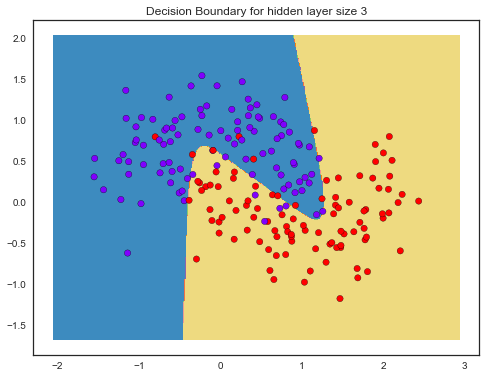

In [9]:
# Plot the decision boundary
plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3");

So this time the model was able to adopt a non-linear decision boundary. It now becomes obivous why the neural network was able to get such good results.

## Checking for convergence

It's also important or at the very lease a good habit to visualize also the cost descent from training the model.

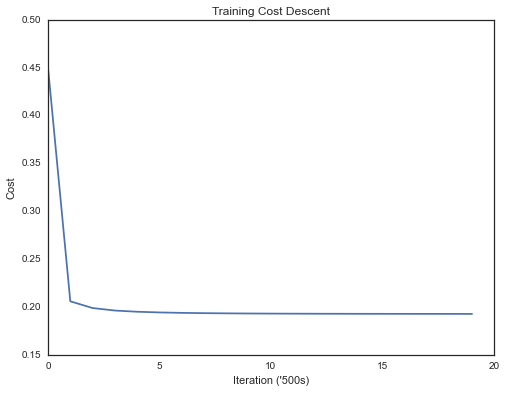

In [10]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");

The cost dropped sharply, which mean the model found its optimal point for the data and converged at that point. The flat curve at the end is a good indication that for this specific configuration of the neural network nothing more can be learned from the data. However a more sofisticated model could possibly extra more meaning from the data than this model. On the other hand, if the curve was not flat, then that would indicate that the model has not reached convergence and that possibly a lower cost can be achieved. In that case, it would be wise to run the model for longer.

## Setting the right learning rate

In [11]:
model = NN.build_model(X, 3, epsilon=0.1)

In this new model, I have increased the learning rate, epsilon, by a factor of ten. This means that at every iterations the step taken towards a minima will be ten times larger. Now let's check our cost descent.

Train Accuracy:  0.825


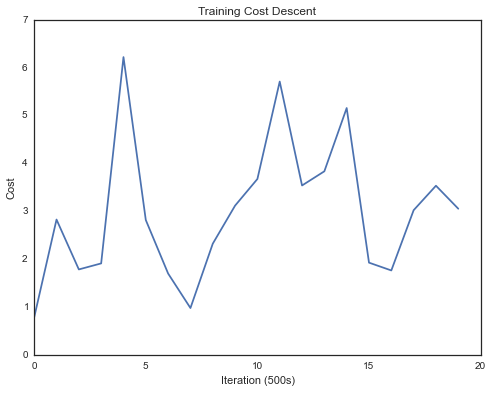

In [12]:
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration (500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");
print "Train Accuracy: ",np.mean(NN.predict(X) == y)

The cost curve is all over the place! This oscillation pattern indicates usually that the step size is too large. The model overshoots everytime the minima, preventing it from converging. As a result, the accuracy is now even lower than logistic model.

## Test Dataset

A better way to evaluate a model is to use an unseen data set. It will allow to tune the model while avoiding overfitting on the training set.

The data below has the same general trend as the training data, but random noise makes it look slightly different. That's exaclty what we want to avoid the model to fit to that noise, while still being able to generalize the trend.

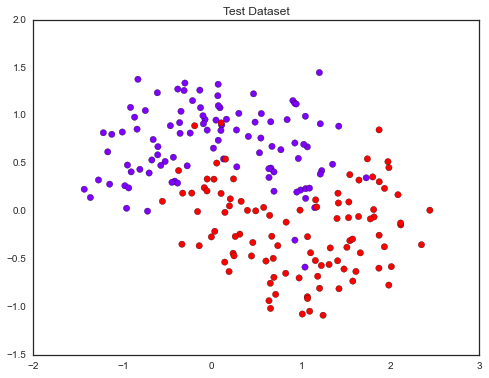

In [13]:
np.random.seed(3)
X_test, y_test = datasets.make_moons(n_samples=200, noise=0.3)
plt.scatter(X_test[:,0],X_test[:,1], s = 40, c = y_test, cmap=plt.cm.rainbow)
plt.title("Test Dataset");

## Bias-Variance Trade-Off

Picking the right number of dimensions for the hidden layer is not obvious. Higher dimensionality will allow the model to aproximate more complex decision boundaries. However, we don't want to the high variance that comes with overly complex models.

Below are visualization of decision boundaries for different number of hidden layer nodes.

(185628,) (372, 499)
(185628,) (372, 499)
(185628,) (372, 499)
(185628,) (372, 499)
(185628,) (372, 499)
(185628,) (372, 499)
(185628,) (372, 499)


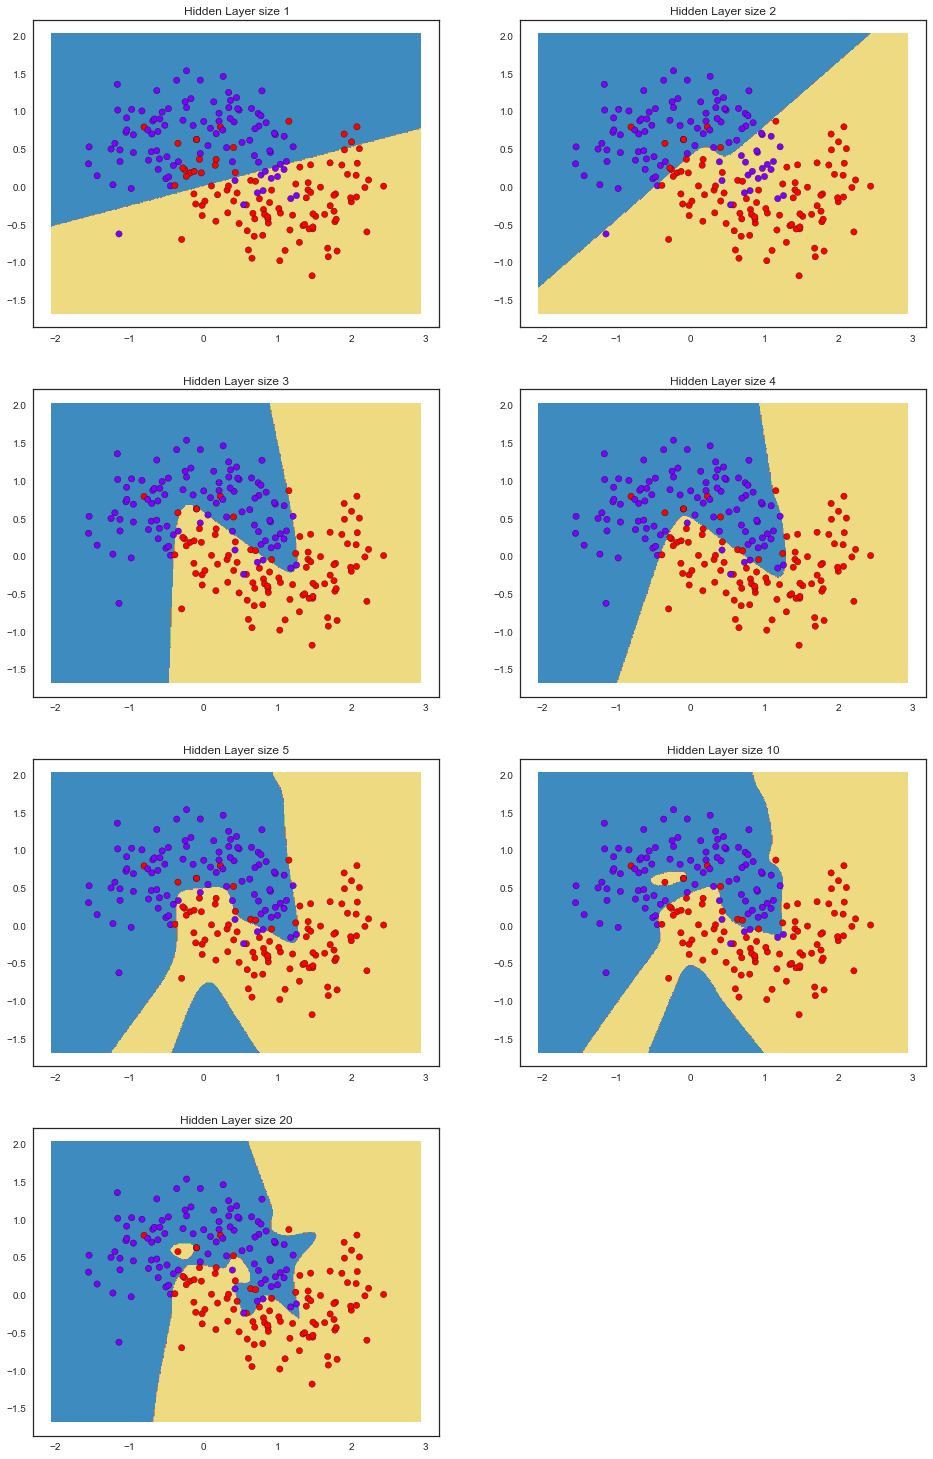

In [14]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 10, 20]

train_error = []
test_error = []
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = NN.build_model(X, nn_hdim)
    
    train_error.append(1 - np.mean(NN.predict(X) == y))
    test_error.append(1 - np.mean(NN.predict(X_test) == y_test))
    
    plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.show()

Interestingly, a hidden layer of size one basically aproximates a linear logisitc regression model. As the size increases, we can oberve the boundary adopting more complex shapes to capture every point of a class. The last plot looks silly. We know intuitively that can't be the optimal decision boundary, however it's probably the model with the best train accuracy. So how do we decide?

Below is graphed the model complexity for both the train and test error rate.

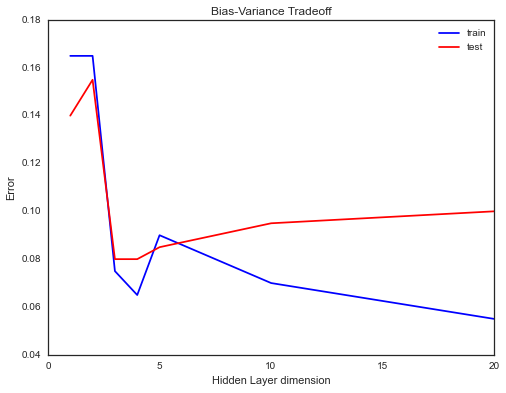

In [15]:
plt.plot(hidden_layer_dimensions, train_error, c = 'b')
plt.plot(hidden_layer_dimensions, test_error , c = 'r')
plt.xlabel("Hidden Layer dimension")
plt.ylabel("Error")
plt.legend(['train', 'test'])
plt.title("Bias-Variance Tradeoff");

The general trend of the train error curve is to decrease with increase model complexity. After some point the model is basically learning every training points by heart, allowing it to achieve very low bias.
However the test error reaches a minimum at 3 or 4 nodes and then climbs back up. This is called the bias-variance tradeoff. When the model starts to fit to the noise of the training set (overfitting), its generalization capacity decreases, which negatively affects the predictions on an unseen data (high variance).

From the plot, an optimal hidden layer size seems to be 3 nodes. It is the model that is able to minimze the most errors on both the train and test set.

## Overfitting's Effect on Test Accuracy

(172752,) (354, 488)
Train Accuracy:  0.955
Test Accuracy:  0.895


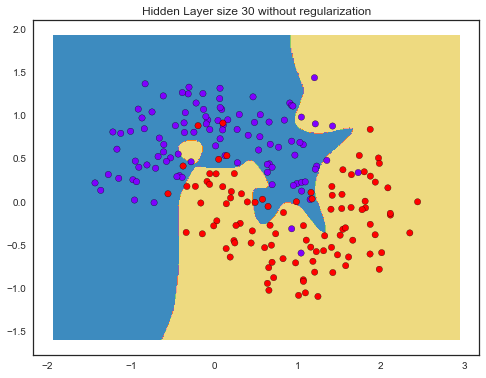

In [16]:
model = NN.build_model(X, 30)
plot_decision_boundary(lambda x: NN.predict(x), X_test, y_test )
plt.title('Hidden Layer size 30 without regularization')
print "Train Accuracy: ",np.mean(NN.predict(X) == y)
print "Test Accuracy: ",np.mean(NN.predict(X_test) == y_test)

Here is ploted the decision boundary of an overly complex model against an unseen test dataset. It is clear in now that the model misclassifies a larger number of points due to its irrational boundary. It's train accuracy is very high, but as expected the test accuracy suffers as a result of overfitting.

## Regularization

Sometimes your model complexity is fixed and you are stuck with a high dimensional model. You can still train your model on a low dimensional response data by introducing regularization. Regularization puts a penalty on high dimensional features and forces the model to generalize and converge to a simpler representation.

Below I have increased the regularizing parameter, lambda, by a factor of ten, while maintaining 30 nodes in the hidden layer.

(172752,) (354, 488)
Train Accuracy:  0.92
Test Accuracy:  0.91


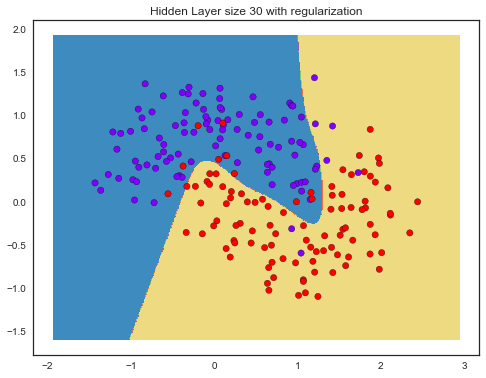

In [17]:
model = NN.build_model(X, 30, reg_lambda= 0.1)
plot_decision_boundary(lambda x: NN.predict(x), X_test, y_test )
plt.title('Hidden Layer size 30 with regularization')
print "Train Accuracy: ",np.mean(NN.predict(X) == y)
print "Test Accuracy: ",np.mean(NN.predict(X_test) == y_test)

Although this model is still more computationally heavy than a simpler model, it was able to correct and simplfy its representation very similar to the one found for only 3 and 4 nodes in the hidden layer. The test accurcay is now much better than before due to its lower vairance.

(172752,) (354, 488)
Train Accuracy:  0.835
Test Accuracy:  0.85


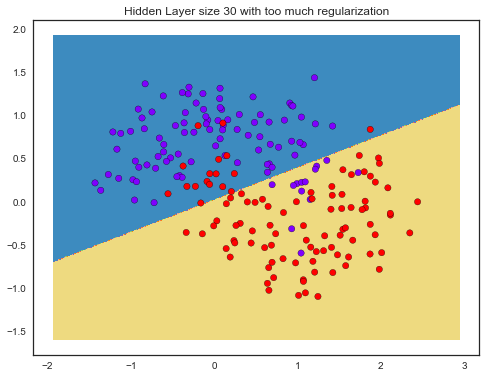

In [18]:
model = NN.build_model(X, 30, reg_lambda= 4)
plot_decision_boundary(lambda x: NN.predict(x), X_test, y_test )
plt.title('Hidden Layer size 30 with too much regularization')
print "Train Accuracy: ",np.mean(NN.predict(X) == y)
print "Test Accuracy: ",np.mean(NN.predict(X_test) == y_test)

However if we increase the regularization too much, the decrease in variance forces the bias back up. We end up with overly simplified model. In fact, in this case we came back full circle with a linear decision boundary just like the linear logistic regression.

There is an important lesson to be learned here. Neural networks can be very powerful, however in other context they can just be overkill for many dataset. It is important to visualize and understand your data before jumping to your favorite Machine Learning algorithm. Otherwise you may end up spending a lot of time fitting and tuning a neural network to your data when an easy and efficient algorithm like logisitc regression would have been prefectly fine. 

## Multi-Class Classification

The neural network can also classify multiple classes, by changing the output nodes dimensions to the number of classes. With sklearn you can easly generate isotropic gaussian clusters to test the model.

Train Accuracy:  0.923333333333
(1253915,) (1313, 955)


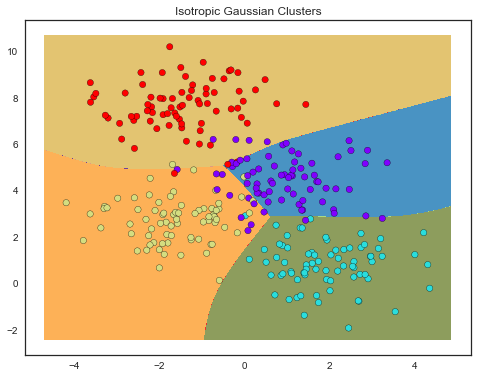

In [32]:
np.random.seed(0)
X, y = datasets.make_blobs(n_samples= 300, n_features=2, centers=4)

NN = NeuralNet(input_dim = 2, output_dim = 4)
model = NN.build_model(X, 4, epsilon=0.005, reg_lambda= 5, num_passes=5000)

print "Train Accuracy: ",np.mean(NN.predict(X) == y)
# Plot the decision boundary
plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.title("Isotropic Gaussian Clusters");

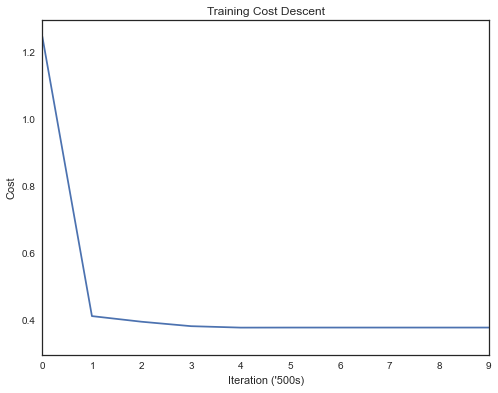

In [33]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");

Train Accuracy:  0.835
(410856,) (646, 636)


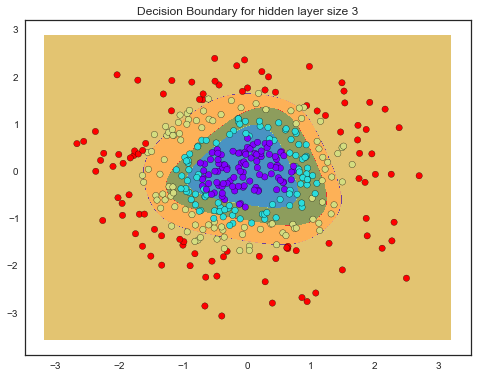

In [27]:
np.random.seed(0)
X, y = datasets.make_gaussian_quantiles(n_samples=400, n_features=2, n_classes=4)

NN = NeuralNet(input_dim = 2, output_dim = 4)
model = NN.build_model(X, 3, epsilon=0.001, reg_lambda= 1, num_passes=10000)

print "Train Accuracy: ",np.mean(NN.predict(X) == y)
# Plot the decision boundary
plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.title("Gaussian Quantiles");

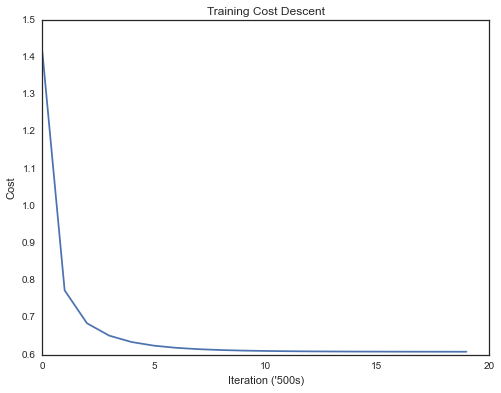

In [28]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");

Train Accuracy:  0.926666666667
(507625,) (655, 775)


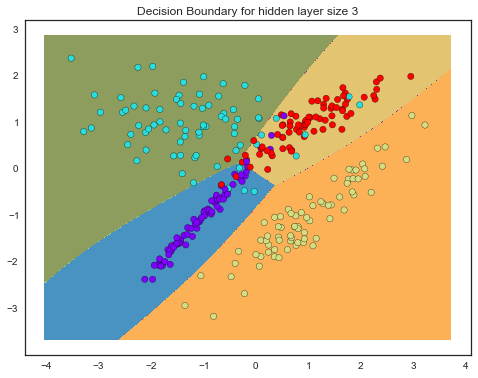

In [29]:
np.random.seed(6)
X, y = datasets.make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                                     n_clusters_per_class=1, n_classes=4)

NN = NeuralNet(input_dim = 2, output_dim = 4)
model = NN.build_model(X, 5, epsilon=0.005, reg_lambda= 2, num_passes=10000)

print "Train Accuracy: ",np.mean(NN.predict(X) == y)
# Plot the decision boundary
plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3");

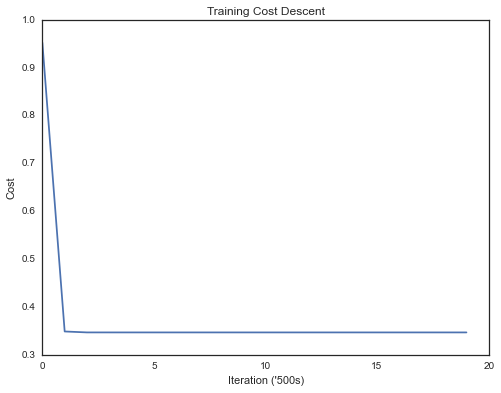

In [30]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");